# Майнор по Анализу Данных, Группа ИАД-2
## 26/04/2017  Алгоритмы кластеризации

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10,5)

font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from ipywidgets import interact, IntSlider, fixed, FloatSlider

In [2]:
RANDOM_SEED = 123

# Пищевая ценность продуктов

Загрузите файл `food.txt`. В нем содержится информация о пищевой ценности разных продуктов

* "Name" is the name of the item.
* "Energy" is the number of calories.
* "Protein" is the amount of protein in grams.
* "Fat" is the amount of fat in grams.
* "Calcium" is the amount of calcium in milligrams.
* "Iron" is the amount of iron in milligrams.

* Подготовте данные к кластеризации - выполните нормализацию признаков
* Сделайте иерархическую кластеризацию этого набора данных.
* Изобразите дендрограмму
* Выверите число кластеров и интерпретируйте их

Почему перед применением кластеризации признки необходимо нормализовать?

Иерархическая кластеризация:
* Агломеративный подход - объединение в кластеры до заданного порога (снизу вверх).
* Дивизивный подход - дробление исходного кластера до заданного порога (сверху вниз).

Проблемы агломерации:
1. Как пересчитывать расстояния между классами? (method)
  * Central Linkage - расстояние до центра класстера. 
  * Single Linkage - ближайшее расстояние до одного из элементов класстера.
  * Complete Linkage - максимальное расстояние до элемента кластера.
  * Average Linkage - ?
  * ...
2. Что такое "похожесть" кластеров?
3. Как посчитать качество (дендрограмма, ARI, силуэт)
4. Выбор порога

In [3]:
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage

In [4]:
df = pd.read_csv('data/food.txt', sep=' ')
df = df.set_index('Name')
df.head()

Energy  Protein  Fat  Calcium  Iron
Name                                             
Braised beef     340       20   28        9   2.6
Hamburger        245       21   17        9   2.7
Roast beef       420       15   39        7   2.0
Beefsteak        375       19   32        9   2.6
Canned beef      180       22   10       17   3.7

In [5]:
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler

In [6]:
normalizer = StandardScaler()
_ = normalizer.fit(df)
X = pd.DataFrame(normalizer.transform(df), columns=df.columns)
X.head()

Energy   Protein       Fat   Calcium      Iron
0  1.335059  0.239681  1.314297 -0.456581  0.152385
1  0.378515  0.479361  0.318516 -0.456581  0.222121
2  2.140569 -0.958723  2.310078 -0.482699 -0.266028
3  1.687470  0.000000  1.676399 -0.456581  0.152385
4 -0.275962  0.719042 -0.315163 -0.352109  0.919476

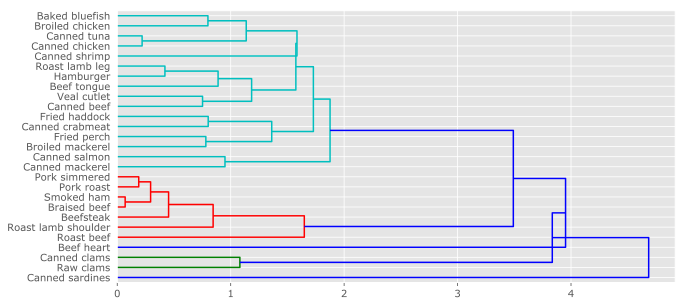

In [7]:
Z = linkage(X, method='median')  # return id clust1, id clust2, distance before combining, size of cluster after mix
dend = dendrogram(Z, labels=df.index, orientation='right')

In [8]:
labels = fcluster(Z, 5, criterion='maxclust')  # get clusters' lables
df.loc[:, 'labels'] = labels
df.head()

Energy  Protein  Fat  Calcium  Iron  labels
Name                                                     
Braised beef     340       20   28        9   2.6       2
Hamburger        245       21   17        9   2.7       3
Roast beef       420       15   39        7   2.0       2
Beefsteak        375       19   32        9   2.6       2
Canned beef      180       22   10       17   3.7       3

In [9]:
df.groupby('labels').mean()
for c, group in df.groupby('labels'):
    print(f"CLUSTER {c}\n{group}")

Energy    Protein        Fat     Calcium      Iron
labels                                                        
1        57.500000   9.000000   1.000000   78.000000  5.700000
2       352.857143  18.571429  30.142857    8.714286  2.414286
3       167.187500  19.812500   8.562500   36.812500  1.725000
4       160.000000  26.000000   5.000000   14.000000  5.900000
5       180.000000  22.000000   9.000000  367.000000  2.500000

CLUSTER 1
              Energy  Protein  Fat  Calcium  Iron  labels
Name                                                     
Raw clams         70       11    1       82   6.0       1
Canned clams      45        7    1       74   5.4       1
CLUSTER 2
                     Energy  Protein  Fat  Calcium  Iron  labels
Name                                                            
Braised beef            340       20   28        9   2.6       2
Roast beef              420       15   39        7   2.0       2
Beefsteak               375       19   32        9   2.6       2
Roast lamb shoulder     300       18   25        9   2.3       2
Smoked ham              340       20   28        9   2.5       2
Pork roast              340       19   29        9   2.5       2
Pork simmered           355       19   30        9   2.4       2
CLUSTER 3
                  Energy  Protein  Fat  Calcium  Iron  labels
Name                                                         
Hamburger            245     

## K-means, метод "локтя" и меры качества кластеризации

Метод "локтя":
$$ J(C) = \sum_{k=1}\sum_{x_i \in C_k}(x_i - \mu_k)^{2} \to min $$

* Загрузите данные по ирисам
* Определите количество кластеров для метода k-means с помощью метода "локтя"
* Выполните кластеризацию и получите вектор с метками кластеров
* Оцените качество кластеризации с помощью
    * ARI
    * Силуэта

In [10]:
from sklearn.datasets import load_iris
from sklearn.metrics import adjusted_rand_score, silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

In [11]:
Xi, yi = load_iris(return_X_y=True)
Xi[:5]

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2]])

In [12]:
_ = normalizer.fit(Xi)
X_norm = pd.DataFrame(normalizer.transform(Xi))
X_norm.head()

0         1         2         3
0 -0.900681  1.032057 -1.341272 -1.312977
1 -1.143017 -0.124958 -1.341272 -1.312977
2 -1.385353  0.337848 -1.398138 -1.312977
3 -1.506521  0.106445 -1.284407 -1.312977
4 -1.021849  1.263460 -1.341272 -1.312977

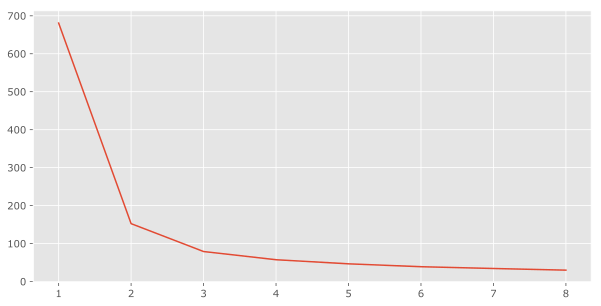

In [13]:
_range = np.arange(1, 9, dtype=int)
scores = []
for k in _range:
    kmeans = KMeans(n_clusters=k)
    _ = kmeans.fit(Xi)
    scores.append(kmeans.inertia_)
_ = plt.plot(_range, scores)

In [14]:
kmeans = KMeans(n_clusters=3)
y_hat = kmeans.fit_predict(Xi)

#### ARI - adjusted random score:
$$ ARI = \frac{a + d}{a + b + c + d}, $$ где:
* a - кол-во пар объектов, которые принадлежат к одному классу в истинном и предсказанном разбиении,
* d - кол-во пар объектов, которые принадлежат разным кластерам в истинном и предсказанном разбиении,
* b - ?
* c - ?

In [15]:
# X_i = linkage  # do with previous data

In [16]:
adjusted_rand_score(yi, y_hat)

0.73023827228346971

## Применение K-means на профилях с интересами

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.

In [17]:
df_sns = pd.read_csv(r"data/snsdata.csv", sep=',')
df_sns.head()

gradyear gender     age  friends  basketball  football  soccer  softball  \
0      2006      M  18.982        7           0         0       0         0   
1      2006      F  18.801        0           0         1       0         0   
2      2006      M  18.335       69           0         1       0         0   
3      2006      F  18.875        0           0         0       0         0   
4      2006    NaN  18.995       10           0         0       0         0   

   volleyball  swimming  ...    blonde  mall  shopping  clothes  hollister  \
0           0         0  ...         0     0         0        0          0   
1           0         0  ...         0     1         0        0          0   
2           0         0  ...         0     0         0        0          0   
3           0         0  ...         0     0         0        0          0   
4           0         0  ...         0     0         2        0          0   

   abercrombie  die  death  drunk  drugs  
0            0    0      0      0      0  
1            0    0      0      0      0  
2            0    0      1      0      0  
3            0    0      0      0      0  
4            0    0      0      1      1  

[5 rows x 40 columns]

Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Интерпретируйте каждый кластер проанализировав полученные центройды

In [18]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer

In [19]:
df_sns_ = df_sns.drop(["gradyear", "gender", "age", "friends"], axis=1)
# df_sns_ = df_sns.iloc[:, 4:].values
df_sns_.head()

basketball  football  soccer  softball  volleyball  swimming  cheerleading  \
0           0         0       0         0           0         0             0   
1           0         1       0         0           0         0             0   
2           0         1       0         0           0         0             0   
3           0         0       0         0           0         0             0   
4           0         0       0         0           0         0             0   

   baseball  tennis  sports  ...    blonde  mall  shopping  clothes  \
0         0       0       0  ...         0     0         0        0   
1         0       0       0  ...         0     1         0        0   
2         0       0       0  ...         0     0         0        0   
3         0       0       0  ...         0     0         0        0   
4         0       0       0  ...         0     0         2        0   

   hollister  abercrombie  die  death  drunk  drugs  
0          0            0    0      0      0      0  
1          0            0    0      0      0      0  
2          0            0    0      1      0      0  
3          0            0    0      0      0      0  
4          0            0    0      0      1      1  

[5 rows x 36 columns]

In [20]:
_ = normalizer.fit(df_sns_)
X_sns = pd.DataFrame(normalizer.transform(df_sns_), columns=df_sns_.columns)
X_sns.head()

basketball  football    soccer  softball  volleyball  swimming  \
0   -0.332217 -0.357697 -0.242874 -0.217928    -0.22367 -0.259971   
1   -0.332217  1.060049 -0.242874 -0.217928    -0.22367 -0.259971   
2   -0.332217  1.060049 -0.242874 -0.217928    -0.22367 -0.259971   
3   -0.332217 -0.357697 -0.242874 -0.217928    -0.22367 -0.259971   
4   -0.332217 -0.357697 -0.242874 -0.217928    -0.22367 -0.259971   

   cheerleading  baseball    tennis    sports    ...       blonde      mall  \
0     -0.207327 -0.201131 -0.168939 -0.297123    ...    -0.050937 -0.369915   
1     -0.207327 -0.201131 -0.168939 -0.297123    ...    -0.050937  1.067392   
2     -0.207327 -0.201131 -0.168939 -0.297123    ...    -0.050937 -0.369915   
3     -0.207327 -0.201131 -0.168939 -0.297123    ...    -0.050937 -0.369915   
4     -0.207327 -0.201131 -0.168939 -0.297123    ...    -0.050937 -0.369915   

   shopping   clothes  hollister  abercrombie       die     death     drunk  \
0 -0.487314 -0.314198  -0.201476    -0.183032 -0.294793 -0.261530 -0.220403   
1 -0.487314 -0.314198  -0.201476    -0.183032 -0.294793 -0.261530 -0.220403   
2 -0.487314 -0.314198  -0.201476    -0.183032 -0.294793  2.027908 -0.220403   
3 -0.487314 -0.314198  -0.201476    -0.183032 -0.294793 -0.261530 -0.220403   
4  2.273673 -0.314198  -0.201476    -0.183032 -0.294793 -0.261530  2.285122   

      drugs  
0 -0.174908  
1 -0.174908  
2 -0.174908  
3 -0.174908  
4  2.719316  

[5 rows x 36 columns]

In [21]:
kmeans_model = KMeans(n_clusters=9, random_state=RANDOM_SEED)
_ = kmeans_model.fit(X_sns)

In [22]:
labels_sns = kmeans_model.labels_
np.bincount(labels_sns)

array([ 5036,  1337,   752,   697, 20024,     1,   846,   466,   841], dtype=int64)

In [23]:
kmeans_model.cluster_centers_.shape

(9, 36)

Центры полученных кластеров.

In [24]:
df_clust = pd.DataFrame(columns=df_sns_.columns, data=kmeans_model.cluster_centers_)
df_clust

basketball  football    soccer  softball  volleyball  swimming  \
0    0.565939  0.518292 -0.066397  0.427820    0.423743  0.279791   
1   -0.080330 -0.053364 -0.111586 -0.044010   -0.062377 -0.008236   
2   -0.123998  0.032560 -0.137037 -0.011186   -0.082365  0.035834   
3    0.200881  0.205740  5.100506  0.020644    0.072273  0.109129   
4   -0.166771 -0.164629 -0.150862 -0.118011   -0.115746 -0.100396   
5   -0.332217  2.477795 -0.242874 -0.217928   -0.223670  1.674334   
6    0.446311  0.438319  0.065131  0.213533    0.156838  0.313919   
7    0.094464  0.065193 -0.051025  0.037368   -0.035881  0.067948   
8    0.153931  0.222213  0.025478  0.076245    0.194404  0.250631   

   cheerleading  baseball    tennis    sports    ...         blonde      mall  \
0      0.394691  0.429664  0.116517  0.312106    ...       0.030970  0.568117   
1     -0.021186 -0.072105 -0.048852 -0.025619    ...       0.001820  0.042894   
2     -0.122005 -0.114469  0.011126 -0.116458    ...      -0.015335 -0.111888   
3     -0.026008  0.027119  0.089168  0.339417    ...       0.032534  0.040450   
4     -0.118389 -0.114889 -0.043069 -0.127404    ...      -0.029211 -0.194711   
5     -0.207327 -0.201131 -0.168939 -0.297123    ...     168.307291 -0.369915   
6      0.224739  0.349424  0.155750  0.947459    ...       0.226575  0.673237   
7      0.001289 -0.032490  0.051070 -0.051132    ...       0.004306 -0.073817   
8      0.393764  0.024503  0.136979  0.104217    ...       0.063544  0.597404   

   shopping   clothes  hollister  abercrombie       die      death      drunk  \
0  0.741558  0.433795  -0.044547    -0.070069  0.016555   0.086319  -0.178602   
1 -0.037131  0.032371  -0.108731    -0.100091  0.147142   0.110054   3.312068   
2 -0.087118 -0.013145  -0.174633    -0.149734 -0.024367   0.018561  -0.133775   
3  0.201942 -0.044030  -0.011159    -0.044461 -0.007622  -0.025032  -0.090992   
4 -0.236516 -0.194064  -0.158130    -0.148912 -0.095444  -0.083977  -0.220403   
5 -0.487314  1.801613  -0.201476    -0.183032  9.312807  13.475099  14.812744   
6  0.326949  1.403960   0.262101     0.341281  1.738021   0.967081   1.233749   
7  0.060736  0.039951  -0.096276    -0.113945  0.299668   0.406632  -0.005336   
8  0.799614  0.583952   4.160115     4.015142  0.042215   0.097811  -0.008878   

      drugs  
0 -0.066266  
1  0.167117  
2 -0.082539  
3 -0.046183  
4 -0.116662  
5 -0.174908  
6  2.941686  
7  0.048681  
8  0.035018  

[9 rows x 36 columns]

In [25]:
for i, row in df_clust.iterrows():
    print("="*10)
    print(f"cluster {i+1}")
    print(row.sort_values(ascending=False).head())

cluster 1
shopping      0.741558
cute          0.630254
mall          0.568117
basketball    0.565939
dance         0.538363
Name: 0, dtype: float64
cluster 2
drunk    3.312068
hair     0.188037
drugs    0.167117
sex      0.152475
die      0.147142
Name: 1, dtype: float64
cluster 3
marching    4.800943
band        3.401470
music       0.381358
rock        0.140320
dress       0.037142
Name: 2, dtype: float64
cluster 4
soccer        5.100506
sports        0.339417
football      0.205740
shopping      0.201942
basketball    0.200881
Name: 3, dtype: float64
cluster 5
blonde   -0.029211
tennis   -0.043069
jesus    -0.075901
death    -0.083977
bible    -0.084725
Name: 4, dtype: float64
cluster 6
blonde    168.307291
sex        19.395543
drunk      14.812744
death      13.475099
hair       10.544693
Name: 5, dtype: float64
cluster 7
kissed    3.478112
drugs     2.941686
hair      2.780309
sex       2.270300
die       1.738021
Name: 6, dtype: float64
cluster 8
bible     4.646021
jesus     3.3

# Геоданные

Загрузите геоданные из `geo_data.txt` (uid, timestamp, lat, lon, location_id).

Будем пытаться кластеризовать данные с помощью DBSCAN и меры [haversine](https://en.wikipedia.org/wiki/Haversine_formula)

In [26]:
try:
    import mpl_toolkits.basemap as bm
except ImportError:
    print("unable to import basemap")
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

unable to import basemap


In [27]:
df_geo = pd.read_csv(r'data/geo_data.txt', sep='\t', header=None, names=['lat', 'lon'])/10000
df_geo.head()

lat      lon
0  62.5983  29.7439
1  62.6146  29.7440
2  62.6144  29.7456
3  62.6004  29.7394
4  62.6018  29.7437

In [28]:
def plot_geo(lat, lon, labels=None):    
    try:
        lllat, lllon = lat.min()-1, lon.max()+1
        urlat, urlon = lat.max()+1, lon.min()-1

        plt.figure(figsize=(10, 10))

        m = bm.Basemap(
            llcrnrlon=lllon,
            llcrnrlat=lllat,
            urcrnrlon=urlon,
            urcrnrlat=urlat, 
            projection='merc',
            resolution='h'
        )

        m.drawcoastlines(linewidth=0.5)
        m.drawmapboundary(fill_color='#47A4C9', zorder=1)
        m.fillcontinents(color='#EBC4D8',lake_color='#47A4C9', zorder=2)

        parallels = np.linspace(lllat, urlat, 10)
        m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
        # draw meridians
        meridians = np.linspace(urlon, lllon, 10)
        m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

        m.scatter(lon, lat, latlon=True, cmap=plt.cm.jet,
              zorder=3, lw=0, c=labels)
    except:
        print('Unable to show map')
        plt.scatter(x=lon, y=lat, c=labels, cmap=plt.cm.jet)
        plt.axis('equal')

Для начала нарисуем все точки на карте

In [34]:
# plot_geo(df_geo.lat.values, df_geo.lon.values)

Мы будем использовать расстояние haversine - на входе требуются координаты в **радианах**. Выход тоже будет в радианах. Чтобы перейти от градусов в радианты мы можем вспомнить тригонометрию, а можем воспользоваться функцией `np.radians`.

Для кого, чтобы не терять связь с реальностью, будем иметь ввиду, что расстояние в 1 радиан на земном шаре равно примерно 6371.0088 километрам.

Создайте матрицу X с координатами в радианах

In [30]:
km_in_radian = 6371.0088
X = np.radians(df_geo)  # *km_in_radian
X[:5]

lat       lon
0  1.092546  0.519129
1  1.092831  0.519131
2  1.092827  0.519159
3  1.092583  0.519050
4  1.092608  0.519125

Как же определить, какие параметры для DBSCAN выставлять? Наибольшую проблемы представляет параметр eps.

Будем считать, что MinPts нам дан свыше (например MinPts = 20). Воспользуемся эвристикой, схожей с методом локтя для оценки eps:

* Расчитайте среднее расстояние до k=MinPts ближайших соседей каждой точки (класс `NearestNeighbors` и метод `kneighbors`)
* Отсортируйте полученный массив и выведите его на график
* Выберите такое расстояние, где будет наблюдаться "перегиб"

In [31]:
nn = NearestNeighbors(n_neighbors=20, algorithm='ball_tree', metric='haversine')
_ = nn.fit(X)

In [32]:
dist_neigh, _ = nn.kneighbors(X, n_neighbors=21)

In [35]:
dist_neigh.shape

(13467, 21)

In [39]:
D = dist_neigh[1:].mean(axis=1)
D[:5]
D = np.sort(D)

array([  4.18137663e-06,   8.58931572e-06,   8.63181637e-06,
         3.01159467e-06,   1.07578061e-05])

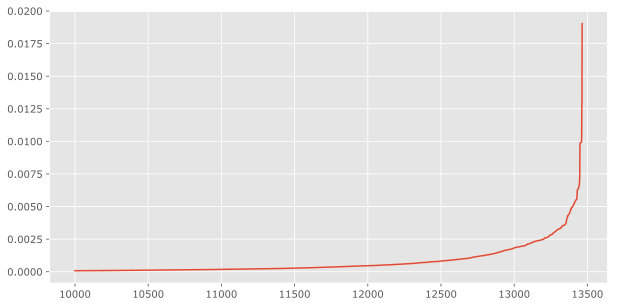

In [43]:
_ = plt.plot(np.arange(0, len(D))[10000:], D[10000:])

Определим eps мы можем начать кластеризацию

* Создайте экземпляр класса DBSCAN, кластеризуйте данные
* Выведите полученные метки кластеров и их частоты
* Изобразите координаты точек, не попавших в кластер выбросов (метка -1)

In [45]:
dbscan = DBSCAN(eps=0.003, min_samples=20, metric='haversine',  algorithm='ball_tree')
_ = dbscan.fit(X)
labels = dbscan.labels_
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18], dtype=int64)